In [1]:
import pickle
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import mlab
import seaborn as sns
%matplotlib inline

mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

In [2]:
import matplotlib.collections as cl

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def RCRPM_loading(RC,RPM,filename,endtype,densitypath):
    with open(densitypath+filename+endtype+'_readcounts.pickle', 'rb') as f:
        RC[filename]=pickle.load(f)
    with open(densitypath+filename+endtype+'_rpm.pickle', 'rb') as f:
        RPM[filename]=pickle.load(f)
    #return [rcs,rpms]

In [5]:
import multiprocessing
import pickle
import threading
from datetime import datetime

print datetime.now()

manager = multiprocessing.Manager()
RC = manager.dict()
RPM = manager.dict()

jobs = []
    
filenames = ['ks170','ks171','ks172','ks182ks110ks83']
endtype = '_3map'
densitypath = '/home/kazuki/^profilingdata/20190503/density_V_options_2/'
for filename in filenames:
    job = multiprocessing.Process(target=RCRPM_loading, args=(RC,RPM,filename,endtype,densitypath))
    jobs.append(job)
    job.start()         
    
[job.join() for job in jobs] # just to get the time by the below line

print datetime.now() 

2019-07-20 17:25:57.865302
2019-07-20 17:26:21.003068


In [6]:
outputfile2 = '/home/kazuki/^data_analysis/^Ecoli_Genome/Positions_ATG_InRNA.csv'
Positions_DataFrame = pd.read_csv(outputfile2)
Positions_DataFrame = Positions_DataFrame.loc[:,~Positions_DataFrame.columns.str.contains('^Unnamed')]

Start = Positions_DataFrame['At_start'].notnull()
notStart = Positions_DataFrame['At_start'].isnull()

inRNA = Positions_DataFrame['In_RNA']=='yes'
not_inRNA = Positions_DataFrame['In_RNA'].isnull()

In [7]:
def get_position_dict(df):
    df.reset_index(inplace=True)
    position_dict = {}
    position_dict['+']=[]
    position_dict['-']=[]
    for i in range(len(df)):
        if df.loc[i,'strand'] == '+':
            position_dict['+'].append(df.loc[i,'ATG'])
        if df.loc[i,'strand'] == '-':
            position_dict['-'].append(df.loc[i,'ATG'])
    return position_dict

def threshold(cut_off,readcountsf_plus, position, upstream_length,downstream_length):
    if sum(readcountsf_plus[position-upstream_length:position+downstream_length])>=cut_off:
        return 'yes'
    else:
        return 'no'

# Calculate Initiation Score    
def peak_ratio(cut_off,readcounts,positions,upstream_length,downstream_length,peak_upstream,peak_downstream):
    peaks = {}
    peaks['+']={}
    peaks['-']={}
    
    total_plus = 0
    readcounts_plus = readcounts[0][readcounts[0].keys()[0]]
    #rpm_plus = rpm[0][rpm[0].keys()[0]]
    position_plus = positions['+']
    for position in position_plus:
        cut_off_result = threshold(cut_off,readcounts_plus,position,upstream_length,downstream_length)
        if cut_off_result == 'yes':  
            total_read = sum(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
            peak_read = sum(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
            if total_read!=0 and peak_read!=0:
                total_plus+=1
                total_average = float(total_read)/len(readcounts_plus[position-upstream_length-1:position+downstream_length-1])
                peak_average = float(peak_read)/len(readcounts_plus[position-peak_upstream-1:position+peak_downstream-1])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['+'][position]=peak_ratio
            
    total_minus = 0
    readcounts_minus = readcounts[1][readcounts[1].keys()[0]]
    #rpm_minus = rpm[1][rpm[1].keys()[0]]
    position_minus = positions['-']
    for position in position_minus:
        cut_off_result = threshold(cut_off,readcounts_minus,position,downstream_length,upstream_length)# opposite as minus       
        if cut_off_result == 'yes':   
            total_read = sum(readcounts_minus[position-downstream_length:position+upstream_length])
            peak_read = sum(readcounts_minus[position-peak_downstream:position+peak_upstream])
            if total_read!=0:
                total_minus+=1
                total_average = float(total_read)/len(readcounts_minus[position-downstream_length:position+upstream_length])
                peak_average = float(peak_read)/len(readcounts_minus[position-peak_downstream:position+peak_upstream])
                if total_average !=0:
                    peak_ratio = float(peak_average)/total_average
                    if peak_ratio != 0:
                        peaks['-'][position]=peak_ratio
    
    return peaks

def get_log2PeakScore(peaks):
    FD=[]
    for strand in peaks.keys():
        FD = FD + peaks[strand].values()
    print len(FD)
    return np.log2(FD)

# Actual analysis of libraries

In [8]:
threshold_setting = 10

distance = 50
upstream_length_setting = distance
downstream_length_setting = distance

peak_upstream = -3
peak_downstream = 21

# NON-start

In [9]:
def IS_violin(df,libraries,facecolor):
    fig, ax = plt.subplots()
    #fig.set_dpi(500)
    fig.set_size_inches(1.2, 2)

    positions = get_position_dict(df)
    data = []
    median_list = []
    for library in libraries:
        peaks=peak_ratio(threshold_setting,RC[library],positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)
        FDs=get_log2PeakScore(peaks)    
        ##
        FDs_omited_too_low = []
        for FD in FDs:
            if FD > -6:
                FDs_omited_too_low.append(FD)
        FDs = np.array(FDs_omited_too_low)     
        ##
        data.append(FDs)
        median_list.append(np.median(FDs))

    result_dict = ax.violinplot(data, showextrema=False, showmedians=False,widths=0.8) 

    for pc in result_dict['bodies']:
        pc.set_facecolor(facecolor)
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    orig_violin = result_dict['bodies'][0]  # in this case, there is only one violin plot, hence [0]
    orig_vertices = orig_violin.get_paths()[0].vertices # extract the vertices coordinates from the Path object contained in the PolyCollection

    top = orig_vertices[orig_vertices[:,1]>=1.5]   # the vertices above the median
    bottom = orig_vertices[orig_vertices[:,1]<=1.5] # and below 

    # create new PolyCollections, adjusting their appearance as desired
    topP = cl.PolyCollection([top])
    topP.set_facecolor('black')
    topP.set_edgecolor('black')
    bottomP = cl.PolyCollection([bottom])
    bottomP.set_facecolor('lightgrey')
    bottomP.set_edgecolor('black')
    ax.add_collection(topP)
    ax.add_collection(bottomP)

    ax = sns.scatterplot(x=[1,2],y=median_list,color='white',zorder=10,s=10)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    sns.despine()

    plt.xlim(0.5,2.5)
    plt.xticks([1,2],['WT','O-mut'])
    plt.ylim(-6.5,3.5)
    plt.yticks([-6,-3,0,3])
    plt.ylabel('IS ($\log_2$)')
    plt.tick_params(labelsize=7)

2892
2438


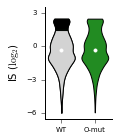

In [10]:
df = Positions_DataFrame[notStart&inRNA]
libraries = ['ks170','ks172']
facecolor = 'forestgreen'

IS_violin(df,libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_A.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

2892
10215


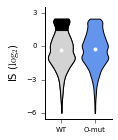

In [11]:
df = Positions_DataFrame[notStart&inRNA]
libraries = ['ks170','ks182ks110ks83']
facecolor = 'cornflowerblue'

IS_violin(df,libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_O.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

2892
3402


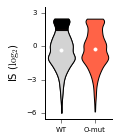

In [12]:
df = Positions_DataFrame[notStart&inRNA]
libraries = ['ks170','ks171']
facecolor = 'tomato'

IS_violin(df,libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_S.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

# genes specifically increased on Non-start

In [13]:
distance = 50
PeakScore_threshold = 1.5 

threshold_setting = 10
peak_upstream = -3
peak_downstream = 21
upstream_length_setting = distance
downstream_length_setting = distance
graph_upstream = upstream_length_setting-25
graph_downstream = upstream_length_setting+50

########################################################################

high_group={}

f = 'ks170'
readcounts = RC[f]
    
df = Positions_DataFrame[notStart&inRNA]
df.reset_index(inplace=True)
position_dict = {}
position_dict['+']=[]
position_dict['-']=[]
for i in range(len(df)):
    if df.loc[i,'strand'] == '+':
        position_dict['+'].append(df.loc[i,'ATG'])
    if df.loc[i,'strand'] == '-':
        position_dict['-'].append(df.loc[i,'ATG'])
positions = position_dict

peaks=peak_ratio(threshold_setting,readcounts,positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)

high_group[f]={}
for strand in peaks.keys():
    high_group[f][strand]={}
    for position in peaks[strand].keys():
        if np.log2(peaks[strand][position]) > PeakScore_threshold:
            high_group[f][strand][position] = peaks[strand][position]

for key in high_group[f].keys():
    print key
    print len(high_group[f][key])

plus_strand = Positions_DataFrame['strand'] == '+'
minus_strand = Positions_DataFrame['strand'] == '-' 
WT_high_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks170']['+'])
WT_high_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks170']['-'])
WT_normal_group_plus = Positions_DataFrame['ATG'].isin(high_group['ks170']['+']) == False
WT_normal_group_minus = Positions_DataFrame['ATG'].isin(high_group['ks170']['-']) == False

+
214
-
280


In [14]:
def df_selector(Positions_DataFrame,which):
    df = Positions_DataFrame[notStart&inRNA]
    df1_1=df[WT_high_group_plus & plus_strand]
    df1_2=df[WT_high_group_minus & minus_strand]
    df1 = pd.concat([df1_1,df1_2])
    df2_1=df[WT_normal_group_plus & plus_strand]
    df2_2=df[WT_normal_group_minus & minus_strand]
    df2 = pd.concat([df2_1,df2_2])
    dfs = [df1,df2]
    return dfs[which]

In [15]:
def IS_violin_sorted(libraries,facecolor):
    data = []
    median_list = []
    for which_df in [0,1]:
        df_to_use = df_selector(Positions_DataFrame,which_df)
        positions = get_position_dict(df_to_use)
        for library in libraries:
            peaks=peak_ratio(threshold_setting,RC[library],positions,upstream_length_setting,downstream_length_setting,peak_upstream,peak_downstream)
            FDs=get_log2PeakScore(peaks)
            ##
            FDs_omited_too_low = []
            for FD in FDs:
                if FD > -6:
                    FDs_omited_too_low.append(FD)
            FDs = np.array(FDs_omited_too_low)     
            ##
            data.append(FDs)
            median_list.append(np.median(FDs))


    fig, ax = plt.subplots()
    #fig.set_dpi(500)
    fig.set_size_inches(2, 2)

    result_dict = ax.violinplot(data, showextrema=False, showmedians=False,widths=0.8) 

    for pc in result_dict['bodies']:
        pc.set_facecolor(facecolor)
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    one_of_violin = result_dict['bodies'][0]  
    one_of_vertices = one_of_violin.get_paths()[0].vertices 
    one_of_P = cl.PolyCollection([one_of_vertices])
    one_of_P.set_facecolor('black')
    one_of_P.set_edgecolor('black')
    ax.add_collection(one_of_P)

    another_violin = result_dict['bodies'][2]  #
    another_vertices = another_violin.get_paths()[0].vertices 
    another_P = cl.PolyCollection([another_vertices])
    another_P.set_facecolor('lightgrey')
    another_P.set_edgecolor('black')
    ax.add_collection(another_P)

    ax = sns.scatterplot(x=[1,2],y=median_list[:2],color='white',zorder=10,s=10)
    ax = sns.scatterplot(x=[3,4],y=median_list[2:4],color='white',zorder=10,s=10)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    sns.despine()

    plt.xlim(0.5,4.5)
    plt.xticks([1,2,3,4],['WT','Mut','WT','Mut'])
    plt.ylim(-6.5,3.5)
    plt.yticks([-6,-3,0,3])
    plt.ylabel('IS ($\log_2$)',fontname="Arial")
    plt.tick_params(labelsize=7)

494
349
2398
2089


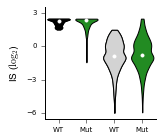

In [16]:
libraries = ['ks170','ks172']
facecolor = 'forestgreen'

IS_violin_sorted(libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_A_highandlow.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

494
364
2398
9851


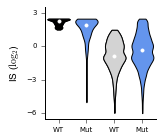

In [17]:
libraries = ['ks170','ks182ks110ks83']
facecolor = 'cornflowerblue'

IS_violin_sorted(libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_A_highandlow.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)

494
387
2398
3015


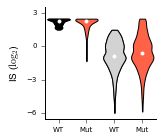

In [18]:
libraries = ['ks170','ks171']
facecolor = 'tomato'

IS_violin_sorted(libraries,facecolor)
#plt.savefig('fig_reta_AGPviolin/ret_violin_nonstart_A_highandlow.pdf', dpi=500, bbox_inches="tight", pad_inches=0.0)